In [1]:
import os
import os.path as op
import mne
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from xml.etree import ElementTree
%matplotlib inline

In [2]:
file_name = 'eyes closed2024.03.11_12.29.58.hdf5'
f = h5py.File(file_name, 'r')
f_keys = list(f.keys())
def printname(name):
    print(name)
#f.visit(printname)
description_data = f.get("RawData/AcquisitionTaskDescription")
description_xml_str = ''
for description in description_data:
    description_xml_str = description.decode('UTF-8')    

In [3]:
#https://mne.tools/dev/auto_tutorials/intro/40_sensor_locations.html

In [4]:
print(mne.channels.get_builtin_montages())

['standard_1005', 'standard_1020', 'standard_alphabetic', 'standard_postfixed', 'standard_prefixed', 'standard_primed', 'biosemi16', 'biosemi32', 'biosemi64', 'biosemi128', 'biosemi160', 'biosemi256', 'easycap-M1', 'easycap-M10', 'easycap-M43', 'EGI_256', 'GSN-HydroCel-32', 'GSN-HydroCel-64_1.0', 'GSN-HydroCel-65_1.0', 'GSN-HydroCel-128', 'GSN-HydroCel-129', 'GSN-HydroCel-256', 'GSN-HydroCel-257', 'mgh60', 'mgh70', 'artinis-octamon', 'artinis-brite23', 'brainproducts-RNP-BA-128']


In [5]:
easycap_montage = mne.channels.make_standard_montage('standard_1020')

In [6]:
#easycap_montage.plot()

In [7]:
tree = ElementTree.fromstring(description_xml_str)
list_of_channels_names = [ChannelName.text for ChannelName in tree.iter('ChannelName')]

In [8]:
sample_shape = f.get("RawData/Samples").shape
raw_data = np.zeros(sample_shape)
f.get("RawData/Samples").read_direct(raw_data)
f.close()

In [9]:
sampling_freq = 512
ch_type_eeg = ['eeg']*64

In [10]:
list_of_channels_names[:3] = ['Fp1','Fpz','Fp2']

In [11]:
info = mne.create_info(ch_names=list_of_channels_names, ch_types=ch_type_eeg, sfreq=sampling_freq)
raw = mne.io.RawArray(np.transpose(raw_data/1e6), info)

Creating RawArray with float64 data, n_channels=64, n_times=92169
    Range : 0 ... 92168 =      0.000 ...   180.016 secs
Ready.


In [12]:
raw.set_montage(easycap_montage)

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,67 points
Good channels,64 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,512.00 Hz
Highpass,0.00 Hz
Lowpass,256.00 Hz


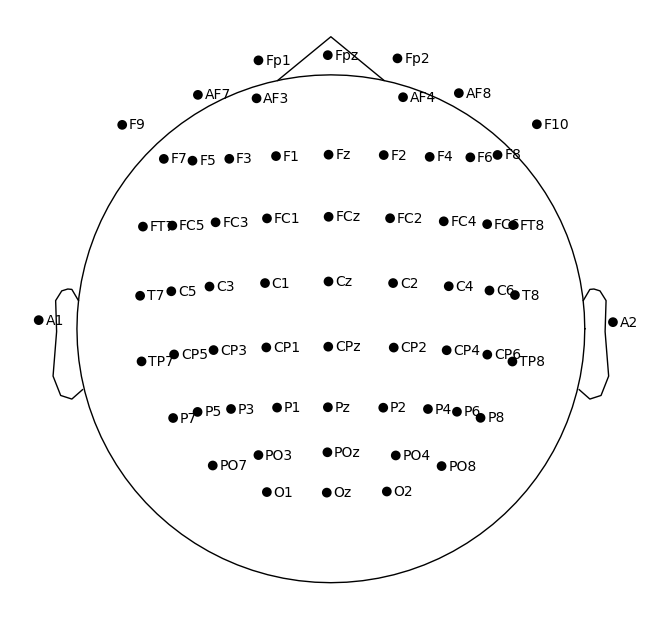

In [13]:
fig = raw.plot_sensors(show_names=True)

In [14]:
def plot_the_eeg_data_subplots(data,title,channel_names,time_range = (0,0),figure_size = (10,18),sampling_freq = 512):
    #plot the eeg data in four subplots(16 channels each)
    #display partial time only works for dataframe data
    if type(data) == pd.core.frame.DataFrame:
        if time_range == (0,0):
            selected_time_data = data
        else:
            start,end = time_range
            selected_time_data = data[(data['time']>=start) & (data['time']<=end)]
        x = selected_time_data['time']
        y = selected_time_data.iloc[:,1:]
    elif type(data) == np.ndarray:
        x = np.arange(0, data.shape[0], 1)
        x = x / sampling_freq
        y = data
    #plt.figure(figsize=fig_size)
    fig, axs = plt.subplots(4,figsize= figure_size)
    fig.suptitle(title)
    sub_titles = ['1-16 channels','17-32 channels','33-48 channels','48-64 channels']
    NUM_COLORS = 16
    #cm = plt.get_cmap('gist_rainbow')
    colors = plt.cm.Spectral(np.linspace(0,1,NUM_COLORS))
    for i in range(4):
        axs[i].set_prop_cycle(color=colors)
        if type(data) == pd.core.frame.DataFrame:
            axs[i].plot(x,y.iloc[:,i*16:(i+1)*16])
        elif type(data) == np.ndarray:
            axs[i].plot(x,y[:,i*16:(i+1)*16])
        axs[i].set_title(sub_titles[i])
        axs[i].legend(channel_names[i*16:(i+1)*16],loc = 'upper right')
        axs[i].set_xlabel('Time [s]')
        axs[i].set_ylabel('Microvolts [mV]')
    fig.tight_layout()
    plt.show()

In [15]:
def plot_the_eeg_data(data,title,channel_names,time_range = (0,0),fig_size = (12,16),sampling_freq = 512):
    #display eeg data in one figure, if dataframe as input,must contain time
    #display partial channels and partial times only works for dataframe data
    if type(data) == pd.core.frame.DataFrame:
        if time_range == (0,0):
            selected_time_data = data
        else:
            start,end = time_range
            selected_time_data = data[(data['time']>=start) & (data['time']<=end)]
        x = selected_time_data['time']
        y = selected_time_data[channel_names]
    else:
        x = np.arange(0, data.shape[0], 1)
        x = x / sampling_freq
        y = data
    #cm = plt.get_cmap('gist_rainbow')
    plt.figure(figsize=fig_size)
    ax = plt.subplot(111)
    num_channels = len(channel_names)
    colors = plt.cm.Spectral(np.linspace(0,1,num_channels))
    #ax.set_prop_cycle(color=[cm(1.*i/num_channels) for i in range(num_channels)])
    ax.set_prop_cycle(color = colors)
    ax.plot(x, y)
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Microvolts [mV]')
    ax.set_title(title)
    ax.legend(channel_names,borderpad=0.2,loc = 'upper right')
    plt.show()

In [17]:
title = 'Plot of the Raw EEG data'
#plot_the_eeg_data(raw_data,title,list_of_channels_names,fig_size = (12,16))

In [ ]:
#plot_the_eeg_data_subplots(raw_data,title,list_of_channels_names)

In [18]:
print(raw.info['ch_names'])

['Fp1', 'Fpz', 'Fp2', 'AF7', 'AF3', 'AF4', 'AF8', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2', 'F9', 'F10', 'A1', 'A2']


In [20]:
reference_channels = list_of_channels_names[62:]

In [21]:
referenced_raw = raw.copy().set_eeg_reference(ref_channels=reference_channels)

EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


In [22]:
referenced_raw_dataframe = referenced_raw.to_data_frame(copy=True)

In [23]:
#referenced_raw.plot()
title = 'Plot of the Referenced EEG data'
#plot_the_eeg_data(referenced_raw_dataframe,title,list_of_channels_names)
#plot_the_eeg_data_subplots(referenced_raw_dataframe,title,list_of_channels_names)

In [24]:
seconds_to_remove = 90

In [25]:
croped_referenced_raw = referenced_raw.copy().crop(tmin=seconds_to_remove, tmax=180.0156)

In [26]:
croped__raw_dataframe = croped_referenced_raw.to_data_frame(copy=True)

In [27]:
title = 'Plot of the Cropped Referenced EEG data'
#plot_the_eeg_data(croped__raw_dataframe,title,list_of_channels_names)
#plot_the_eeg_data_subplots(croped__raw_dataframe,title,list_of_channels_names)

In [28]:
sorted_std_channels = croped__raw_dataframe.iloc[:,1:].std().sort_values(ascending = False)
print(sorted_std_channels)

Oz     2824.624447
O2      946.185256
Cz      245.807901
PO7     196.041345
POz     187.505697
          ...     
TP8      15.287450
PO8      14.225231
Fp2      13.600359
AF3      13.361627
TP7      11.455673
Length: 64, dtype: float64


In [29]:
mean_std = sorted_std_channels.mean()
print('mean value of channel std',mean_std)
std_of_std = sorted_std_channels.std()
print('std of channel std',std_of_std)

mean value of channel std 102.14647758214878
std of channel std 366.4254350188196


<Axes: >

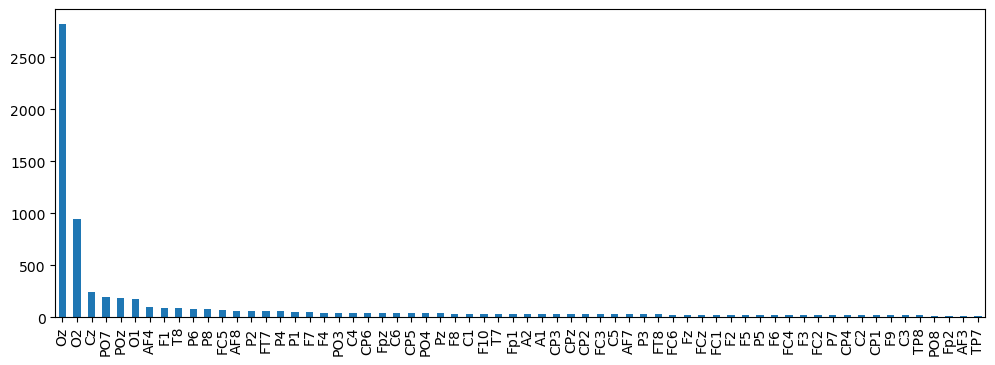

In [30]:
sorted_std_channels.plot(kind = 'bar',figsize = (12,4))

In [31]:
print(sorted_std_channels[:20])

Oz     2824.624447
O2      946.185256
Cz      245.807901
PO7     196.041345
POz     187.505697
O1      172.153740
AF4      93.545131
F1       83.343638
T8       82.381421
P6       78.713222
P8       74.479212
FC5      70.326274
AF8      59.496087
P2       57.197372
FT7      55.776011
P4       55.126569
P1       52.431513
F7       43.775448
F4       43.232908
PO3      42.211336
dtype: float64


In [32]:
channels_to_remove = sorted_std_channels.index[:6] #determined by looking at the barplot

In [33]:
#channels_to_remove = ['O1'] #visualize individual channels

In [34]:
title = 'visualize the channels with large standard deviation'
#plot_the_eeg_data(croped__raw_dataframe,title,channels_to_remove)

In [35]:
croped__raw_dataframe = croped__raw_dataframe.drop(columns = channels_to_remove)

In [36]:
title = 'visualize the channels after removal of bad channels'
#plot_the_eeg_data(croped__raw_dataframe,title,croped__raw_dataframe.columns[1:])

In [37]:
bad_removed_eeg = croped_referenced_raw.copy().drop_channels(list(channels_to_remove))

In [38]:
new_channels = croped__raw_dataframe.columns[1:]

In [39]:
raw_welch_psd = bad_removed_eeg.compute_psd(method='welch',n_fft=int(20*512))

Effective window size : 20.000 (s)


In [41]:
#raw_welch_psd.plot(dB = True)

In [43]:
raw_psd_df = raw_welch_psd.to_data_frame(copy=True)

In [44]:
raw_psd_df.iloc[:,1:] = 10*np.log10(raw_psd_df.iloc[:,1:]*1e12)

In [45]:
def plot_the_psd_data(data,title,channel_names,freq_range = (0,0),fig_size = (12,16)):
    #display psd data in one figure,freq_range requires a (min_freq,max_freq)
    #data must be dataframe format, must have frequeny column
    if freq_range == (0,0):
        selected_freq_psd = data
    else:
        start,end = freq_range
        selected_freq_psd = data[(data['freq']>=start) & (data['freq']<end)]
    x = selected_freq_psd['freq']
    y = selected_freq_psd[channel_names]
    #cm = plt.get_cmap('gist_rainbow')
    plt.figure(figsize=fig_size)
    ax = plt.subplot(111)
    num_channels = len(channel_names)
    colors = plt.cm.Spectral(np.linspace(0,1,num_channels))
    #ax.set_prop_cycle(color=[cm(1.*i/num_channels) for i in range(num_channels)])
    ax.set_prop_cycle(color = colors)
    ax.plot(x, y)
    ax.set_xlabel('Frequency [Hz]')
    ax.set_ylabel('Power/Frequency [dB/Hz]')
    ax.set_title(title)
    ax.legend(channel_names,borderpad=0.2,loc = 'upper right')
    plt.show()

In [46]:
title = 'Full PSD'
#plot_the_psd_data(raw_psd_df,title,new_channels)

In [47]:
title = 'PSD from 0-30 Hz'
#plot_the_psd_data(raw_psd_df,title,new_channels,(0,30))

In [48]:
low_cut = 0.1
hi_cut  = 30
raw_filt = bad_removed_eeg.copy().filter(low_cut,hi_cut)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16897 samples (33.002 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


In [49]:
raw_filt = raw_filt.copy().notch_filter(60, method='fir')

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 3381 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


In [50]:
raw_filt_dataframe = raw_filt.to_data_frame(copy=True)

In [53]:
title = 'Plot of the Filtered EEG data'
#plot_the_eeg_data_subplots(raw_filt_dataframe,title,new_channels)

In [55]:
#plot_the_eeg_data(raw_filt_dataframe,title,raw_filt_dataframe.columns[1:],fig_size = (12,16))

In [56]:
raw_filt_welch_psd = raw_filt.compute_psd(method='welch',n_fft=int(20*512))

Effective window size : 20.000 (s)


In [58]:
#raw_filt_welch_psd.plot()

In [59]:
raw_filt_psd_df = raw_filt_welch_psd.to_data_frame(copy=True)
raw_filt_psd_df.iloc[:,1:] = 10*np.log10(raw_filt_psd_df.iloc[:,1:]*1e12)

In [60]:
title = 'Full PSD of Filtered Data'
#plot_the_psd_data(raw_filt_psd_df,title,new_channels)

In [61]:
#title = 'PSD from 0-30 Hz of Filtered Data'
#plot_the_psd_data(raw_filt_psd_df,title,new_channels,(0,30))

In [62]:
print(len(new_channels))

58


In [63]:
ica = mne.preprocessing.ICA(n_components=56,max_iter='auto',random_state=97)

In [64]:
raw_for_ica = raw_filt.copy().filter(l_freq=1, h_freq=None)
ica.fit(raw_for_ica)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 s)

Fitting ICA to data using 58 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Selecting by number: 56 components
Fitting ICA took 70.0s.


C:\Users\81236\anaconda3\envs\mne\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,1000 iterations on raw data (46089 samples)
ICA components,56
Available PCA components,58
Channel types,eeg
ICA components marked for exclusion,—


In [65]:
ica.plot_sources(raw_for_ica,show_scrollbars=True)

Creating RawArray with float64 data, n_channels=56, n_times=46089
    Range : 46080 ... 92168 =     90.000 ...   180.016 secs
Ready.


In [66]:
remove_list = [0,2,3,5,9]

Applying ICA to Raw instance
    Transforming to ICA space (56 components)
    Zeroing out 5 ICA components
    Projecting back using 58 PCA components


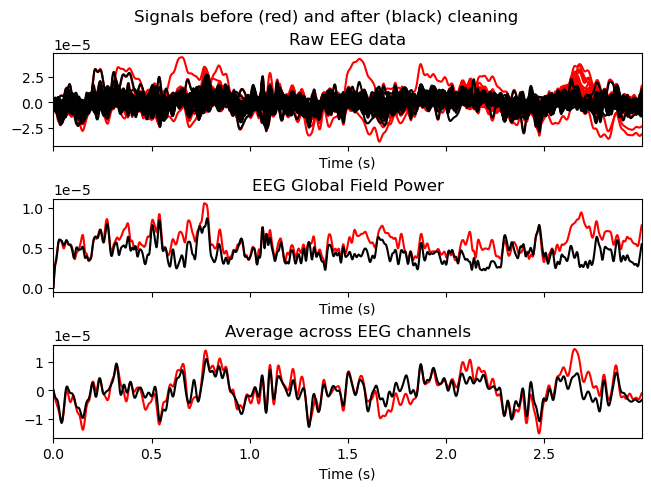

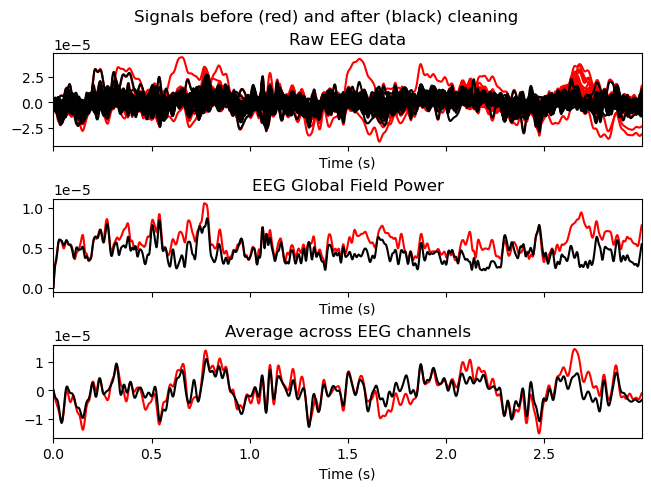

In [67]:
ica.plot_overlay(raw_for_ica, exclude=remove_list)

In [68]:
ica.exclude = remove_list

In [69]:
ica.apply(raw_filt)

Applying ICA to Raw instance
    Transforming to ICA space (56 components)
    Zeroing out 5 ICA components
    Projecting back using 58 PCA components


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,67 points
Good channels,58 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,512.00 Hz
Highpass,0.10 Hz
Lowpass,30.00 Hz


In [70]:
sources = ica.get_sources(raw_for_ica)

In [71]:
ica_components_data_frame = sources.to_data_frame(copy=True)

In [72]:
ica_components_data_frame.shape

(46089, 57)

In [73]:
ICA_columns = ica_components_data_frame.columns[1:]

In [74]:
title = 'plot of all ICA components'

In [77]:
#plot_the_eeg_data(ica_components_data_frame,title,ICA_columns[30],time_range = (80,120),fig_size = (15,12),sampling_freq = 512)

In [78]:
after_ica_dataframe = raw_filt.to_data_frame(copy=True)

In [79]:
title = 'plot of data after ICA removal'

In [81]:
#plot_the_eeg_data(after_ica_dataframe,title,new_channels,time_range = (0,0),fig_size = (15,12),sampling_freq = 512)

In [83]:
#plot_the_eeg_data_subplots(after_ica_dataframe,title,new_channels,sampling_freq = 512)

In [84]:
afterICA_welch_psd = raw_filt.compute_psd(method='welch',n_fft=int(20*512))

Effective window size : 20.000 (s)


In [86]:
#afterICA_welch_psd.plot()

In [87]:
afterICA_psd_df = afterICA_welch_psd.to_data_frame(copy=True)
afterICA_psd_df.iloc[:,1:] = 10*np.log10(afterICA_psd_df.iloc[:,1:]*1e12)

In [89]:
title = 'Full PSD of afterICA data'
#plot_the_psd_data(afterICA_psd_df,title,new_channels)

In [91]:
title = 'PSD from 0-30 Hz of afterICA data'
#plot_the_psd_data(afterICA_psd_df,title,new_channels,freq_range = (0,30))

In [93]:
title = 'PSD of afterICA data Delta Band'
#plot_the_psd_data(afterICA_psd_df,title,new_channels,freq_range = (0,3))

In [96]:
title = 'PSD of afterICA data Theta Band'
#plot_the_psd_data(afterICA_psd_df,title,new_channels,freq_range = (3,7))

In [98]:
title = 'PSD of afterICA data Alpha Band'
#plot_the_psd_data(afterICA_psd_df,title,new_channels,freq_range = (7,12))

In [100]:
title = 'PSD of afterICA data Beta Band'
#plot_the_psd_data(afterICA_psd_df,title,new_channels,freq_range = (12,30))

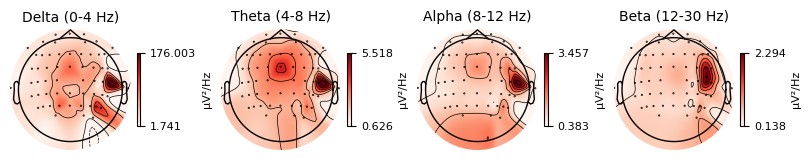

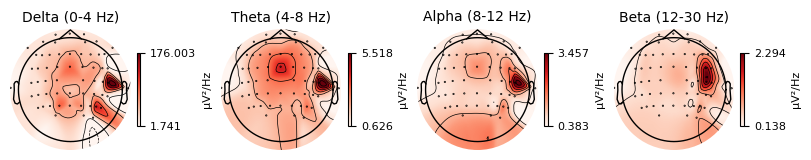

In [122]:
afterICA_welch_psd.plot_topomap(bands = {'Delta (0-4 Hz)': (0, 4), 'Theta (4-8 Hz)': (4, 8),
'Alpha (8-12 Hz)': (8, 12), 'Beta (12-30 Hz)': (12, 30)},cmap = 'Reds')

In [ ]:
def compute_the_average_band_power(psd,band_range):
    band_low,band_high = band_range
    psd_in_selected_band = psd[(psd['freq']>=band_low) & (psd['freq']<band_high)]
    average_band_power = psd_in_selected_band.mean()
    return average_band_power

In [ ]:
#compute_the_average_band_power(afterICA_psd_df,(0,3)).plot(kind = "bar")

In [ ]:
#compute_the_average_band_power(afterICA_psd_df,(3,7))

In [ ]:
tuples_of_bands = ((0,3),(3,7),(7,12),(12,30))

In [ ]:
def compute_the_relative_band_power(psd,tuples_of_bands):
    band_sum = 0
    list_of_bands = []
    for band_tuple in tuples_of_bands:
        band_low,band_high = band_tuple
        psd_in_selected_band = psd[(psd['freq']>=band_low) & (psd['freq']<band_high)]
        sum_of_band = psd_in_selected_band.iloc[:,1:].sum()
        list_of_bands.append(sum_of_band)
        band_sum+= sum_of_band
    return list_of_bands,band_sum